# Landscape of (linear/non-linear) one-dimensional convnets with/without normalization

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from mpl_toolkits import mplot3d

from matplotlib import gridspec

GPU = False
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor


In [2]:
def pad_circular1d(x, pad):
    x = torch.cat([x, x[0:pad]])
    x = torch.cat([x[-2 * pad:-pad], x])
    return x

class Pad1d(torch.nn.Module):
    def __init__(self, pad):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(Pad1d, self).__init__()
        self.pad = pad
        
    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        shape = [1,x.shape[1],x.shape[2]+2*self.pad]
        xx = Variable(torch.zeros(shape)).type(dtype)
        for i in range(x.shape[1]):
            xx[0,i] = pad_circular1d(x[0,i],self.pad)
        return xx # pad_circular1d(x, self.pad)

In [3]:
def print_filters(net):
    for m in net.modules():
        if isinstance(m, nn.Conv1d):
            print(m.weight.data.cpu().numpy())  

def plot_gradients(out_grads):
    for i,g in enumerate(out_grads):
        plt.semilogy(g,label=str(i)) 
    plt.legend()
    plt.show()

# test conv
n = 4
shape = [1,1,n]
y = Variable( torch.tensor(np.array([[[1,2,3,4]]])) ).type(dtype)
print(y)

cl = conv(1, 1, 3, stride=1,bias=False,pad=True)
#print( cl.convolver.weights.data )

def initialize(net):
    for m in net.modules():
        if isinstance(m, nn.Conv1d):
            if m.weight.data.shape[2]>1:
                m.weight.data[0,0,0] = 0
                m.weight.data[0,0,1] = 1
                m.weight.data[0,0,2] = 2


tensor([[[1., 2., 3., 4.]]])


In [4]:
def conv1d(in_f, out_f, kernel_size, stride=1,bias=False,pad=True):
    '''
    Circular convolution
    '''
    to_pad = int((kernel_size - 1) / 2)
    if pad:
        padder = Pad1d(to_pad)
    else:
        padder = None

    #convolver = nn.utils.weight_norm(nn.Conv1d(in_f, out_f, kernel_size, stride, padding=0, bias=bias), name='weight')
    convolver = nn.Conv1d(in_f, out_f, kernel_size, stride, padding=0, bias=bias)
    
    layers = filter(lambda x: x is not None, [padder, convolver])
    return nn.Sequential(*layers).type(dtype)


def initialize(net):
    for m in net.modules():
        if isinstance(m, nn.Conv1d):
            if m.weight.data.shape[2]>1:
                m.weight.data[0,0,0] = 0
                m.weight.data[0,0,1] = 1
                m.weight.data[0,0,2] = 1
                m.weight.data[0,0,3] = 0
                m.weight.data[0,0,4] = 0


In [5]:
class ChannelNormalization(torch.nn.Module):
    '''
    Different ways to normalize the channels
    '''
    def __init__(self, D_in,mode="BN"):
        self.mode = mode
        super(ChannelNormalization, self).__init__()
        self.gamma = nn.Parameter(torch.ones(D_in))
        self.beta = nn.Parameter(torch.zeros(D_in))
        
    def forward(self, x):
        xx = Variable(torch.zeros(x.shape)).type(dtype)
        for i,(g,b) in enumerate(zip(self.gamma,self.beta)):
            #print(i, x[0][i].shape)
            if self.mode == "BN":
                #xx[0][i] = (x[0][i] - torch.mean(x[0][i]))/torch.sqrt( torch.var(x[0][i]) + 0.00001 ) * g  + b
                xx[0][i] = (x[0][i] - torch.mean(x[0][i]))/torch.sqrt( torch.var(x[0][i]) + 0.00001 ) + b
            elif self.mode == "mult":
                xx[:,i] = x[:,i]*g + b
            elif self.mode == "non-learned":
                xx[0][i] = (x[0][i] - torch.mean(x[0][i]))/torch.sqrt( torch.var(x[0][i]) + 0.00001 )
            elif self.mode == "center":
                xx[:,i] = (x[:,i] - torch.mean(x[:,i]))
            elif self.mode == "normalize":
                xx[0][i] = (x[0][i])/torch.sqrt( torch.var(x[0][i]) )
            elif self.mode == "only+bias":
                xx[:,i] = x[:,i] + b
            elif self.mode == "onlycenter+bias":
                xx[:,i] = (x[:,i] - torch.mean(x[:,i]))*g + b
            elif self.mode == "almostcenter":
                xx[:,i] = ( (x[:,i] - torch.mean(x[:,i])) + torch.mean(x[:,i]) / torch.from_numpy( np.sqrt( np.array([np.prod(x[0][i].shape)]) ) ).float().type(dtype)) /torch.sqrt( torch.var(x[0][i]) + 0.00001 ) + b
            elif self.mode == "center+scale":
                xx[:,i] =  (x[:,i] - torch.mean(x[:,i])) / (torch.max( torch.abs(x[:,i] - torch.mean(x[:,i]) ) ) + 0.00001)
            elif self.mode == "center+mean_scale":
                xx[:,i] =  (x[:,i] - torch.mean(x[:,i])) / torch.mean(torch.abs( x[:,i] - torch.mean(x[:,i]) ) )
            elif self.mode == "scale":
                z =  x[0][i]
                xx[0][i] = z / ( torch.norm(z) + 0.00001 )*g + b
            elif self.mode == "linear":
                xx = x
            else:
                raise ValueError('not an option for channel normalization.')
        return xx

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_f, out_f, kernel_size, stride=1,bias=False,pad=True,mode="BN"):
        super(ResidualBlock, self).__init__()
        self.conv = conv(in_f, out_f, kernel_size, stride=stride,bias=bias,pad=pad)
        self.norm = ChannelNormalization(in_f,mode=mode)
    def forward(self, x):
        residual = x
        out = self.conv(x)
        out = self.norm(out)
        out += residual
        return out

def decnet(
        num_output_channels=1, 
        num_channels_up=[1]*5, 
        filter_size_up=2,
        act_fun=nn.ReLU(), # nn.LeakyReLU(0.2, inplace=True) 
        mode = "BN",
        modeout = "none",
        res = True,
        ):
    
    num_channels_up = num_channels_up + [num_channels_up[-1]]
    n_scales = len(num_channels_up) 
    
    model = nn.Sequential()

    for i in range(len(num_channels_up)-1):
        if res:
            model.add(ResidualBlock(num_channels_up[i], num_channels_up[i+1],  filter_size_up, 1,mode))
        else:

            model.add(conv1d( num_channels_up[i], num_channels_up[i+1],  filter_size_up, 1))
            if act_fun != None:
                model.add(act_fun)
            model.add(ChannelNormalization(num_channels_up[i],mode=mode))
            #model.add( nn.BatchNorm1d( num_channels_up[i] ,affine=True) )

            
    if modeout != "none":
        model.add(ChannelNormalization(num_channels_up[i+1],mode=modeout))
        #model.add( nn.BatchNorm1d( num_channels_up[i+1] ,affine=True) )
    model.add(conv1d(num_channels_up[-1], num_output_channels, 1, bias=True,pad=False))
    # model.add(nn.Sigmoid())
    
    return model


In [7]:
def fit(net,
        y,
        num_channels,
        net_input = None,
        num_iter = 5000,
        LR = 0.01,
       ):

    if net_input is not None:
        print("input provided")
    else:
        length = int(y.data.shape[2])
        shape = [1,num_channels[0], length ]
        print("input shape: ", shape)
        net_input = Variable(torch.ones(shape)).type(dtype)
        net_input.data.uniform_()
        
    
    net_input = net_input.type(dtype)
    net_input_saved = net_input.data.clone()
    noise = net_input.data.clone()
    p = [x for x in net.parameters() ]

    mse_wrt_noisy = np.zeros(num_iter)
     
    print("optimize with SGD", LR)
    optimizer = torch.optim.SGD(p, lr=LR,momentum=0)
    
    mse = torch.nn.MSELoss() #.type(dtype) 
   
    nconvnets = 0
    for p in list(filter(lambda p: len(p.data.shape)>2, net.parameters())):
        nconvnets += 1
    
    out_grads = np.zeros((nconvnets,num_iter))
    out_filters = np.zeros((nconvnets+1,num_iter))
    init_para = np.zeros((9,nconvnets+1))
    for i in range(num_iter):
        def closure():
            optimizer.zero_grad()
            out = net(net_input.type(dtype))

            # training loss 
            loss = mse(out, y)
            loss.backward()
            mse_wrt_noisy[i] = loss.data.cpu().numpy()
            
            # output gradients
            for ind,p in enumerate(list(filter(lambda p: p.grad is not None and len(p.data.shape)>2, net.parameters()))):
                out_grads[ind,i] = p.grad.data.norm(2).item()
            
            # output norms of filters
            ind = 0
            for m in net.modules():
                if isinstance(m, nn.Conv1d):
                    out_filters[ind,i] = m.weight.data.norm(2).item()
                    if i == 0:
                        init_para[:,ind] = m.weight.data.numpy()[0,0]
                    ind += 1
                    #print(m.weight.data.cpu().numpy()) 
        
                   
            if i % 10 == 0:
                print ('Iteration %05d    Train loss %f' % (i, loss.data), '\r', end='')
            
            return loss   
        
        loss = optimizer.step(closure)
                  
    return mse_wrt_noisy, net_input, net, out_grads, out_filters

In [13]:
def loss_eval(x_coordinate,y_coordinate,num_channels,net,net_input,net_target,kernel_size=9,mode='non-learned', \
              act_fun = nn.ReLU()):
    
    X_coordinate, Y_coordinate = np.meshgrid(x_coordinate, y_coordinate)
    Z = np.zeros(X_coordinate.shape)
    depth = len(num_channels)
    
    net_coor = decnet(1,num_channels,kernel_size,act_fun=act_fun,mode=mode,res=False).type(dtype)
    net_coor[len(net)-1][0].weight.data = net[len(net)-1][0].weight.data
    net_coor[len(net)-1][0].bias.data = net[len(net)-1][0].bias.data
    
    net_dir1 = decnet(1,num_channels,kernel_size,act_fun=act_fun,mode=mode,res=False).type(dtype)
    net_dir2 = decnet(1,num_channels,kernel_size,act_fun=act_fun,mode=mode,res=False).type(dtype)
    
    unit_depth = int((len(net)-1)/depth)
    for ii in range(len(x_coordinate)):
        for jj in range(len(y_coordinate)):
            for k in range(len(num_channels)):
                net_coor[unit_depth*k][1].weight.data = net[unit_depth*k][1].weight.data + \
                x_coordinate[ii]*net_dir1[unit_depth*k][1].weight.data + y_coordinate[jj]*net_dir2[unit_depth*k][1].weight.data
            net_out = net_coor(net_input) 
            Z[ii,jj] = nn.MSELoss()(net_out,net_target)
    return X_coordinate, Y_coordinate, Z



def weight_init(m):
    torch.manual_seed(np.random.choice(100, 1))
    if isinstance(m, nn.Linear):
        xavier(m.weight.data)

        
        
def plot_loss_landscape(net_input, net_target, mode = 'non-learned', num_chan = 4, depth = 10, kernel_size = 9, \
                        act_fun =nn.ReLU(), num_iter = 2000):
    num_channels = [num_chan]*depth
    net = decnet(1,num_channels,kernel_size,act_fun= act_fun,mode=mode,res=False).type(dtype)
    # print(net)
    mse_NL, ni, net, out_grads_NL, out_norms = fit(net,net_target,num_channels,net_input = net_input,num_iter = num_iter, \
                                                   LR = 0.1)
    
    x_coordinate = np.linspace(-2,2,30)
    y_coordinate = np.linspace(-2,2,30)
    X_coordinate, Y_coordinate, Z = loss_eval(x_coordinate,y_coordinate,num_channels,net,net_input,net_target,kernel_size,mode,act_fun)
                
    return X_coordinate, Y_coordinate, Z

## Multi-channel CNN with ReLU Layers

### generate signals

In [9]:
n = 256

# noise
shape = [1,1,n]
y = Variable(torch.zeros(shape),requires_grad=False).type(dtype)
y.data.uniform_()
y_np = y.data.cpu().numpy()[0,0]

# step function
ystep_np = np.zeros([1,n])
ystep_np[0,:int(n/2)] = np.ones(int(n/2))
ystep_1 = np_to_var(ystep_np).type(dtype)
# print(ystep.shape)

shape = [1,4,n]
# print("input shape: ", shape)
net_input_1 = Variable(torch.ones(shape)).type(dtype)
net_input_1.data.uniform_()

tensor([[[0.5024, 0.7259, 0.8837,  ..., 0.3580, 0.4741, 0.6730],
         [0.5471, 0.3724, 0.8293,  ..., 0.4137, 0.9296, 0.9379],
         [0.6239, 0.3397, 0.4512,  ..., 0.2039, 0.8455, 0.4360],
         [0.7788, 0.5482, 0.5163,  ..., 0.0034, 0.8642, 0.9816]]])

### With Channel Normalization

input provided
optimize with SGD 0.1


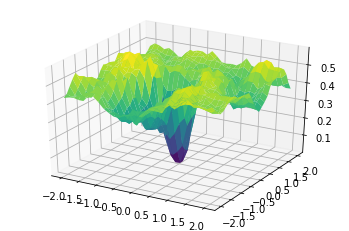

In [14]:
X_coordinate, Y_coordinate, Z = plot_loss_landscape(net_input_1, ystep_1, mode = 'non-learned')

fig = plt.figure()
fig = plt.axes(projection='3d')
fig.plot_surface(X_coordinate, Y_coordinate, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

### Without Normalization

input provided
optimize with SGD 0.1


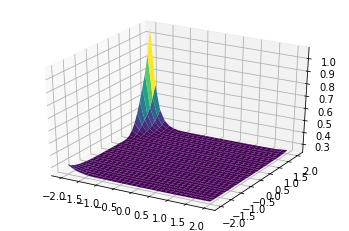

In [15]:
X_coordinate, Y_coordinate, Z = plot_loss_landscape(net_input_1, ystep_1, mode = 'linear')

fig = plt.figure()
fig = plt.axes(projection='3d')
fig.plot_surface(X_coordinate, Y_coordinate, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

## Single-channel linear CNN

### Generate Signals

In [28]:
n = 64

# noise
shape = [1,1,n]
y = Variable(torch.zeros(shape),requires_grad=False).type(dtype)
y.data.uniform_()
y_np = y.data.cpu().numpy()[0,0]

# step function
ystep_np = np.zeros([1,n])
ystep_np[0,:int(n/3)] = np.ones(int(n/3))
ystep_2 = np_to_var(ystep_np).type(dtype)

net_input_2 = Variable(torch.ones(shape)).type(dtype)
net_input_2.data.uniform_()
print(net_input_2.shape)


torch.Size([1, 1, 64])


### With Channel Normalization

input provided
optimize with SGD 0.1


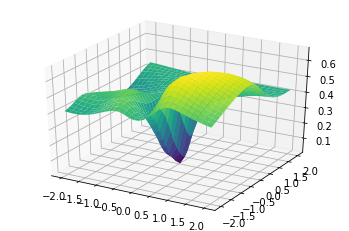

In [20]:
X_coordinate, Y_coordinate, Z = plot_loss_landscape(net_input_2, ystep_2, mode = 'non-learned', num_chan = 1, act_fun = None)

fig = plt.figure()
fig = plt.axes(projection='3d')
fig.plot_surface(X_coordinate, Y_coordinate, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

### Without Normalization

input provided
optimize with SGD 0.1


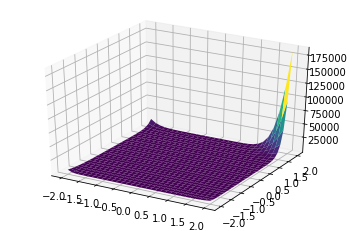

In [19]:
X_coordinate, Y_coordinate, Z = plot_loss_landscape(net_input_2, ystep_2, mode = 'linear', num_chan = 1, act_fun = None)

fig = plt.figure()
fig = plt.axes(projection='3d')
fig.plot_surface(X_coordinate, Y_coordinate, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

## Combine the Figures

input provided
optimize with SGD 0.1
input provided0    Train loss 0.000005                                                                                                    
optimize with SGD 0.1
input provided0    Train loss 0.249999                                                                                                                                                                                                        
optimize with SGD 0.1
input provided0    Train loss 0.009534                                                                                                                                                                                                        
optimize with SGD 0.1


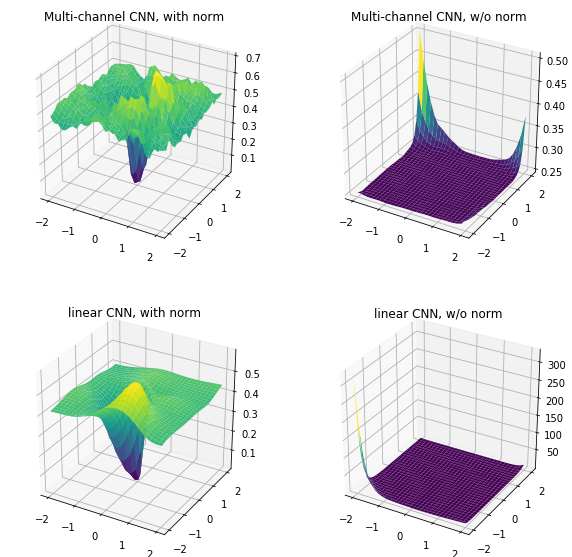

In [29]:
from matplotlib import gridspec

plot = plt.figure(figsize=(10,10))

X_coordinate, Y_coordinate, Z = plot_loss_landscape(net_input_1, ystep_1, mode = 'non-learned',num_iter=1000)
fig = plot.add_subplot(2, 2, 1, projection='3d')
fig.set_title("Multi-channel CNN, with norm")
fig.plot_surface(X_coordinate, Y_coordinate, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

X_coordinate, Y_coordinate, Z = plot_loss_landscape(net_input_1, ystep_1, mode = 'linear')
fig = plot.add_subplot(2, 2, 2, projection='3d')
fig.set_title("Multi-channel CNN, w/o norm")
fig.plot_surface(X_coordinate, Y_coordinate, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')


X_coordinate, Y_coordinate, Z = plot_loss_landscape(net_input_2, ystep_2, mode = 'non-learned', num_chan = 1, act_fun = None)
fig = plot.add_subplot(2, 2, 3, projection='3d')
fig.set_title("linear CNN, with norm")
fig.plot_surface(X_coordinate, Y_coordinate, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

X_coordinate, Y_coordinate, Z = plot_loss_landscape(net_input_2, ystep_2, mode = 'linear', num_chan = 1, act_fun = None)
fig = plot.add_subplot(2, 2, 4, projection='3d')
fig.set_title("linear CNN, w/o norm")
fig.plot_surface(X_coordinate, Y_coordinate, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

In [30]:
plot.savefig('C:/Reinhard Research Projects/ICLR workshop/Visualize Network/Loss_Landscape.pdf')